<a href="https://colab.research.google.com/github/2theb/2theb.github.io/blob/master/%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%A7%88%EC%9D%B4%EB%8B%9D_%EA%B8%B0%EB%B2%95%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EB%B9%84%EC%A0%95%ED%98%95_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_%EB%B0%8F_%EC%8B%A4%EC%8A%B5_210928.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 텍스트 마이닝 기법을 이용한 비정형 데이터 분석 및 실습
---
2021.09.28.  

국토모니터링연구센터 국토데이터랩  
부연구위원 이영민 

# 1) 개요

- 사용 언어: Python
- 개발 환경: 구글 코랩 이용 [(클릭하면 코랩으로 이동!)](https://colab.research.google.com/notebooks/welcome.ipynb?hl=ko)
- 활용 데이터: 네이버 영화 리뷰 [(클릭하면 저장소(깃허브)로 이동!)](https://github.com/e9t/nsmc/)
- 참고 서적 및 사이트: [딥 러닝을 이용한 자연어 처리 입문](https://wikidocs.net/44249)

# 2) 오픈 데이터 입출력

In [1]:
# 코랩에서 작업 시 matplotlib 한글 폰트 오류 문제 해결하는 방법(리눅스 쉘 명령어)

# 1. 나눔 폰트 다운로드 
!sudo apt-get install -y fonts-nanum # '나눔(nanum)' 이라는 단어가 포함된 폰트 패키지를 모두 설치하라
!sudo fc-cache -fv # 폰트 캐시 갱신
!rm ~/.cache/matplotlib -rf # Matplotlib의 폰트 캐시를 삭제하라

# 2. 1번 실행 후 상단 메뉴에서 '런타임' > '런타임 다시 시작' 클릭!

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,547 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155013 files and d

In [1]:
######### '런타임 다시 시작' 후 여기서부터 실행 ######### 
# 한국어 처리를 위한 konlpy 설치
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 448 kB 28.6 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
# 필요한 함수 호출
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import matplotlib as mpl
import re
import numpy as np
from collections import Counter
import time
from konlpy.tag import Okt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image

# matplotlib의 폰트를 나눔(Nanum)폰트로 지정
plt.rc('font', family='NanumBarunGothic')

In [3]:
# 네이버 영화 리뷰 테스트 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt",
                           filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fce06bc1490>)

In [4]:
# 다운로드한 리뷰 데이터 불러오기
data = pd.read_table('ratings_test.txt')

In [5]:
# 리뷰 데이터 개수 출력
print('리뷰 데이터 개수: ',len(data))

리뷰 데이터 개수:  50000


In [6]:
# 리뷰 데이터 앞에서부터 5개 출력
data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# 3) 결측값 및 중복 제거

## 3-1) 결측값 제거


In [8]:
# NaN(Not a Number: 결측값을 뜻함) 탐지
print(data.isnull().values.any())

# True 출력 시 결측값이 있다는 의미

True


In [9]:
# 결측값(NaN)이 몇 개 있는지 확인
data.isnull().sum()

id          0
document    3
label       0
dtype: int64

In [10]:
# document값이 NaN인 행의 인덱스 확인
data.loc[data.document.isnull()]

,id,document,label
5746,402110,NaN,1
7899,5026896,NaN,0
27097,511097,NaN,1


In [11]:
# NaN 값이 존재하는 행 제거하기
# (how='any'): NaN값이 하나라도 있으면 해당 행 삭제
data = data.dropna(how='any') 

In [12]:
# 다시 한번 NaN 있는지 확인
print(data.isnull().values.any())

# False 출력 시 결측값이 없다는 의미

False


In [13]:
# 결측값 제거 후 리뷰 데이터 개수 출력
print('결측값 제거 후 리뷰 데이터 개수: ',len(data))

결측값 제거 후 리뷰 데이터 개수:  49997


## 3-2) 중복 제거


In [14]:
#'documnet'열과 'label'열에서 각각 유니크한 값(중복이 아닌 값)의 개수 구하기
data['document'].nunique(), data['label'].nunique()

# 총 49,997개의 샘플이 있는데, documnet열에서 유니크한 샘플의 개수가 49,157개라는 것은 
# 840개의 중복 샘플이 존재한다는 의미

# label열은 0 또는 1 값만 가지므로 '2'가 출력된 것

(49157, 2)

In [15]:
# document열 중복 제거
# keep='first': 중복이 있을 시 첫 번째 값 남기기
# inplace=True: 원본 DataFrame에서 중복 데이터 제거
data.drop_duplicates(subset=['document'], keep='first', inplace=True)

In [16]:
# 중복 제거 후 샘플 수 확인
print('중복 제거 후 샘플의 수 :',len(data))

중복 제거 후 샘플의 수 : 49157


## 3-3) 그래프를 이용한 데이터 시각화


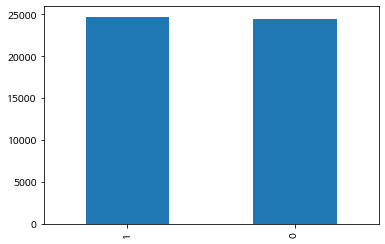

In [17]:
# label(긍정: 1, 부정: 0) 값 count 결과 시각화
data['label'].value_counts().plot(kind = 'bar')

# rot=0: x축 레이블 각도
# data['label'].value_counts().plot(kind = 'bar', rot=0)

# 그림 크기 조정
# data['label'].value_counts().plot(kind = 'bar', rot=0, figsize=(8, 6))

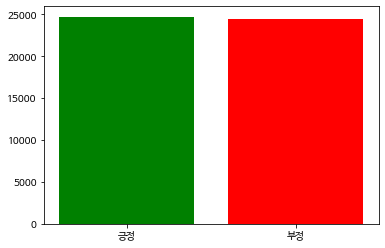

In [18]:
# 바 그래프 심화버전 1
# x축 레이블 및 색상 변경하기
plt.bar(['긍정', '부정'], data['label'].value_counts(), color=['g', 'r'])
plt.show()

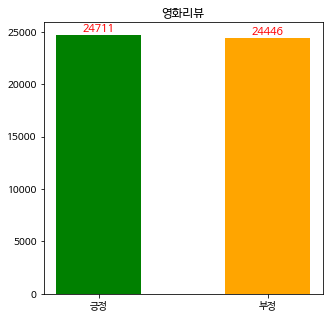

In [19]:
# 바 그래프 심화버전 2
# 그래프에 텍스트 추가하기
xLabel = list(data['label'].unique())  # x축 값
xLabel = [str(int) for int in xLabel] # 숫자를 문자(string)으로 변환
y = list(data['label'].value_counts()) # y축 값

plt.figure(figsize=(5, 5)) # 그래프 사이즈 지정
plt.bar(xLabel, y, color=['g', 'orange'], width=0.5)
plt.xticks(xLabel, ['긍정', '부정'])
plt.title('영화리뷰')

for i, v in enumerate(xLabel):
    plt.text(v, y[i], y[i],               # 텍스트 표시할 좌표(x축, y축, 텍스트)
             fontsize = 11, 
             color='red',
             horizontalalignment='center', # horizontalalignment (left, center, right)
             verticalalignment='bottom')   # verticalalignment (top, center, bottom)

plt.show()

## 3-4) 긍정 리뷰와 부정 리뷰 분리하기


In [20]:
# 긍정(label: 1) 리뷰 추출
condition_posi = (data.label == 1) # 조건식 작성
data_posi = data[condition_posi]
print('긍정 리뷰 개수 확인: ', len(data_posi))

긍정 리뷰 개수 확인:  24711


In [21]:
# 부정(label:0) 리뷰 추출
condition_neg = (data.label == 0) # 조건식 작성
data_neg = data[condition_neg]
print('부정 리뷰 개수 확인: ', len(data_neg))

부정 리뷰 개수 확인:  24446


# 4) KoNLPy 기반 한국어 형태소 분석

## 4-1) 영어로 맛보기


In [22]:
# 영어로 테스트: 알파벳과 공백을 제외하고 모두 제거
text = 'do!!! you expect.. 25 people~ to~ the FAQ, etc.accept 58 hard~! atheism?@@'

print('원글                       : ', text)
print('알파벳과 공백 제외하고 제거: ', re.sub(r'[^a-zA-Z ]', '', text))

원글                       :  do!!! you expect.. 25 people~ to~ the FAQ, etc.accept 58 hard~! atheism?@@
알파벳과 공백 제외하고 제거:  do you expect  people to the FAQ etcaccept  hard atheism


In [23]:
# 숫자는 남기고 싶다면 [0-9] 
print('원글                            : ', text)
print('알파벳과 공백 제외하고 제거     : ', re.sub(r'[^a-zA-Z ]', '', text))
print('알파벳, 공백, 숫자 제외하고 제거: ', re.sub(r'[^a-zA-Z0-9 ]', '', text))

원글                            :  do!!! you expect.. 25 people~ to~ the FAQ, etc.accept 58 hard~! atheism?@@
알파벳과 공백 제외하고 제거     :  do you expect  people to the FAQ etcaccept  hard atheism
알파벳, 공백, 숫자 제외하고 제거:  do you expect 25 people to the FAQ etcaccept 58 hard atheism


## 4-2) 정규식 기반 불용어 제거


### (1) 긍정 리뷰

In [24]:
# 한글 제외하고 모두 제거
data_posi = data_posi.copy()
data_posi['document'] = data_posi['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]","", regex=True)

# white space 제거
data_posi['document'] = data_posi['document'].str.replace('^ +', "", regex=True) 

# 데이터 확인
data_posi[:5]

,id,document,label
0,6270596,굳 ㅋ,1
5,7898805,음악이 주가 된 최고의 음악영화,1
9,6242223,이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But 모든 사람이 그렇지는 않네,1
10,7462111,괜찮네요오랜만포켓몬스터잼밌어요,1
12,6900881,청춘은 아름답다 그 아름다움은 이성을 흔들어 놓는다 찰나의 아름다움을 잘 포착한 섬...,1


In [25]:
# 빈 값을 NaN으로 변경
data_posi['document'].replace('', np.nan, inplace=True)

In [26]:
# 결측값(NaN) 개수 확인
print(data_posi.isnull().sum())

id           0
document    18
label        0
dtype: int64


In [27]:
# Nan 있는 행 출력
print(data_posi.loc[data_posi.document.isnull()][:5])

           id document  label
116   6910486      NaN      1
1000  7710606      NaN      1
1532   294803      NaN      1
6544  7887700      NaN      1
6945  7664094      NaN      1


In [28]:
# NaN값 제거하고 크기 확인
data_posi = data_posi.dropna(how = 'any')
print('전처리 후 샘플의 개수 :', len(data_posi))

전처리 후 샘플의 개수 : 24693


### (2) 부정 리뷰

In [29]:
# 한글 제외하고 모두 제거
data_neg = data_neg.copy()
data_posi['document'] = data_posi['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]","", regex=True)

# white space 제거
data_neg['document'] = data_neg['document'].str.replace('^ +', "", regex=True) 

# 데이터 확인
data_neg[:5]

,id,document,label
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
6,6315043,진정한 쓰레기,0


In [30]:
# 빈 값을 NaN으로 변경
data_neg['document'].replace('', np.nan, inplace=True)

# 결측값(NaN) 개수 확인
print(data_neg.isnull().sum())

# Nan 있는 행 출력
print('='*50)
print(data_neg.loc[data_neg.document.isnull()][:5])

# NaN값 제거하고 크기 확인
data_neg = data_neg.dropna(how = 'any')
print('='*50)
print('전처리 후 샘플의 개수 :', len(data_neg))

id          0
document    0
label       0
dtype: int64
Empty DataFrame
Columns: [id, document, label]
Index: []
전처리 후 샘플의 개수 : 24446


## 4-3) 토큰화

In [31]:
# 형태소 분석기 테스트 - 텍스트 형태소 단위로 분할(stem=True: 어간 추출)
okt = Okt()
okt.morphs('지루하지는 않은데 완전 막장임 돈주고 보기에는', stem = True)

['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']

In [32]:
# 형태소 분석기 테스트 - 품사 태깅(stem=True: 어간 추출)
okt.pos('지루하지는 않은데 완전 막장임 돈주고 보기에는', stem = True)

[('지루하다', 'Adjective'),
 ('않다', 'Verb'),
 ('완전', 'Noun'),
 ('막장', 'Noun'),
 ('임', 'Noun'),
 ('돈', 'Noun'),
 ('주다', 'Verb'),
 ('보기', 'Noun'),
 ('에는', 'Josa')]

In [33]:
# 긍정 리뷰 작업
start = time.time() # 시작 시간 측정

data_posi_tag = []
for sentence in data_posi['document']:
    data_temp = okt.pos(sentence, stem=True) # 토큰화
    data_posi_tag.append(data_temp)
    
# 코드 돌린 데 걸린 시간 측정
print("코드 도는 데 걸린 시간 :", time.time() - start) # 끝 시간 - 시작 시간

# 값 확인
print("="*50)
data_posi_tag[:2]

코드 도는 데 걸린 시간 : 57.8727068901062


[[('굳다', 'Adjective'), ('ㅋ', 'KoreanParticle')],
 [('음악', 'Noun'),
  ('이', 'Josa'),
  ('주가', 'Noun'),
  ('되다', 'Verb'),
  ('최고', 'Noun'),
  ('의', 'Josa'),
  ('음악', 'Noun'),
  ('영화', 'Noun')]]

In [34]:
# 부정 리뷰 작업
start = time.time() # 시작 시간 측정

data_neg_tag = []
for sentence in data_neg['document']:
    data_temp = okt.pos(sentence, stem=True) # 토큰화
    data_neg_tag.append(data_temp)
    
# 코드 돌린 데 걸린 시간 측정
print("코드 도는 데 걸린 시간 :", time.time() - start) # 끝 시간 - 시작 시간

# 값 확인
print("="*50)
data_neg_tag[:2]

코드 도는 데 걸린 시간 : 51.470786333084106


[[('GDNTOPCLASSINTHECLUB', 'Alpha')],
 [('뭐', 'Noun'),
  ('야', 'Josa'),
  ('이', 'Noun'),
  ('평점', 'Noun'),
  ('들', 'Suffix'),
  ('은', 'Josa'),
  ('....', 'Punctuation'),
  ('나쁘다', 'Adjective'),
  ('않다', 'Verb'),
  ('10', 'Number'),
  ('점', 'Noun'),
  ('짜다', 'Verb'),
  ('리', 'Noun'),
  ('는', 'Josa'),
  ('더', 'Noun'),
  ('더욱', 'Noun'),
  ('아니다', 'Adjective')]]

# 5) 워드 클라우드를 활용한 데이터 시각화


## 5-1) 특정 품사 추출해 빈도수 세기


In [35]:
# 불용어 지정해 주기
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', 
             '없다', '있다', '같다', '아니다', '않다', '정말', '진짜', '생각', '영화', '이렇다', '그렇다', 
             '보고', '때문']

### (1) 긍정 리뷰

In [36]:
noun_adj_list_posi = []
for i in range(len(data_posi_tag)):
    for word, tag in data_posi_tag[i]:
        if not word in stopwords and tag in ['Noun', 'Adjective', 'KoreanParticle'] and len(word) > 1: 
            noun_adj_list_posi.append(word)

# 값 확인하기
print('명사, 형용사, KoreanParticle에 해당하는 단어 개수:', len(noun_adj_list_posi))
print(noun_adj_list_posi[:10])

명사, 형용사, KoreanParticle에 해당하는 단어 개수: 127527
['굳다', '음악', '주가', '최고', '음악', '이별', '아픔', '새롭다', '인연', '기쁨']


In [37]:
# 빈도수 높은 단어부터 top100 저장하기
counts_posi = Counter(noun_adj_list_posi)
tags_posi = counts_posi.most_common(100)

# 값 확인하기
tags_posi[:10]

[('좋다', 2932),
 ('재밌다', 2517),
 ('최고', 1815),
 ('감동', 1290),
 ('연기', 1236),
 ('재미있다', 1118),
 ('드라마', 1003),
 ('평점', 927),
 ('사랑', 836),
 ('다시', 821)]

### (2) 부정 리뷰

In [38]:
noun_adj_list_neg = []
for i in range(len(data_neg_tag)):
    for word, tag in data_neg_tag[i]:
        if not word in stopwords and tag in ['Noun', 'Adjective', 'KoreanParticle'] and len(word) > 1: 
            noun_adj_list_neg.append(word)

# 값 확인하기
print('명사, 형용사, KoreanParticle에 해당하는 단어 개수:', len(noun_adj_list_neg))
print(noun_adj_list_neg[:10])

# 빈도수 높은 단어부터 top50 저장하기 
counts_neg = Counter(noun_adj_list_neg)
tags_neg = counts_neg.most_common(50)

# 값 확인하기
print("="*50)
tags_neg[:10]

명사, 형용사, KoreanParticle에 해당하는 단어 개수: 129278
['평점', '나쁘다', '더욱', '지루하다', '완전', '막장', '보기', '다섯', '심기', '불편하다']


[('아깝다', 1349),
 ('평점', 1287),
 ('재미없다', 1080),
 ('좋다', 1070),
 ('스토리', 1067),
 ('쓰레기', 1006),
 ('연기', 941),
 ('감독', 938),
 ('내용', 935),
 ('그냥', 932)]

## 5-2) 워드 클라우드 기반 시각화


In [39]:
# 시각화 결과 바로보기
%matplotlib inline

In [40]:
# 코랩에서 작업 시 - 한국어 폰트가 위치한 경로 설정
font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

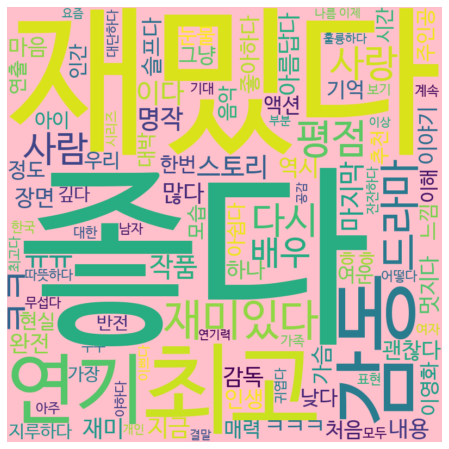

In [41]:
# 긍정 리뷰 시각화
wordcloud = WordCloud(
    font_path = font_path,
    width = 800,            
    height = 800,
    background_color="pink",
)

wordcloud = wordcloud.generate_from_frequencies(dict(tags_posi))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# 파일로 저장하기
plt.savefig('posi_wordcloud_movie_review.png', dpi=300)

plt.show()

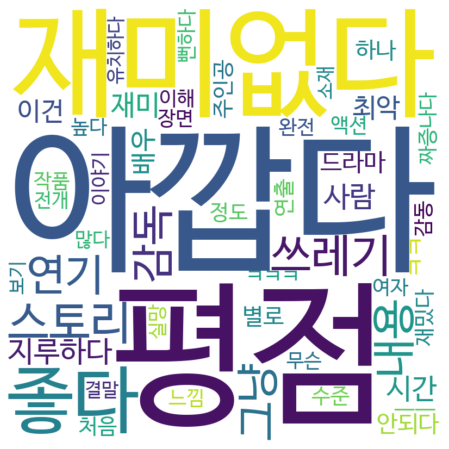

In [42]:
# 부정 리뷰 시각화
wordcloud = WordCloud(
    font_path = font_path,
    width = 800,
    height = 800,
    background_color="white",
)

wordcloud = wordcloud.generate_from_frequencies(dict(tags_neg))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# 파일로 저장하기
plt.savefig('neg_wordcloud_movie_review.png', dpi=300)

plt.show()

## 5-3) 워드 클라우드 기반 시각화 심화버전(마스크 이용)


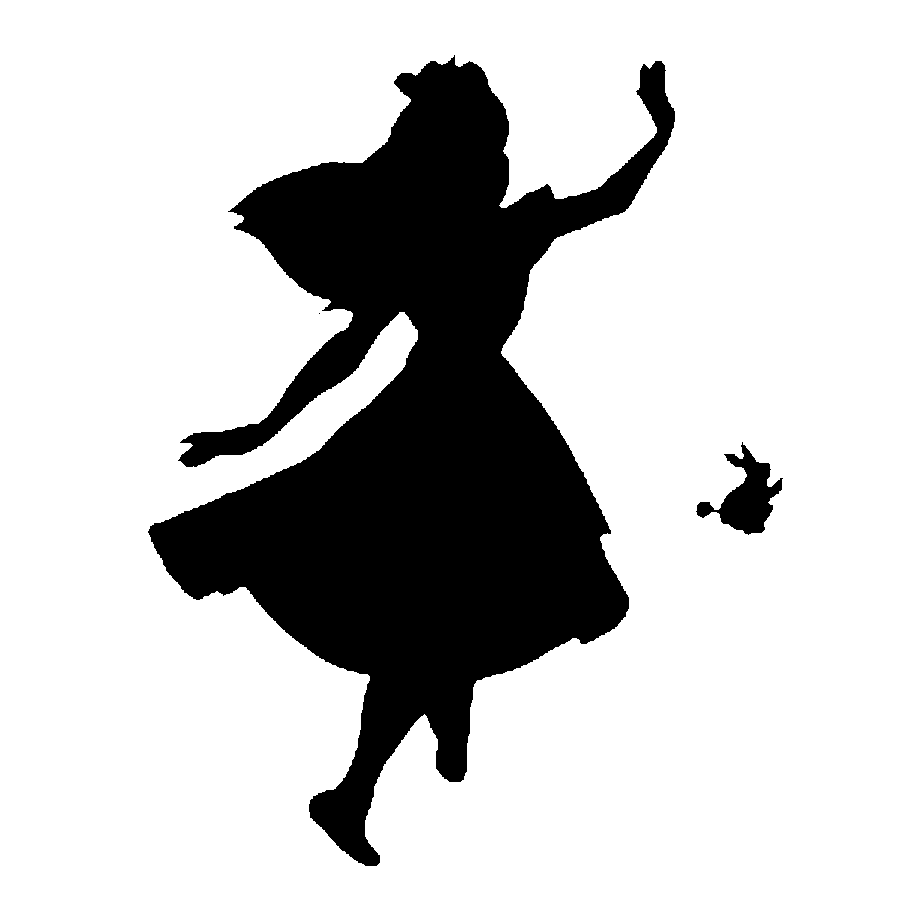

In [43]:
# 웹에서 마스크 이미지 가져오기
url = "https://lovit.github.io/assets/figures/alice_mask.png"
urllib.request.urlretrieve(url, "alice_mask.png")
img = Image.open("alice_mask.png")

# 이미지 확인하기
img

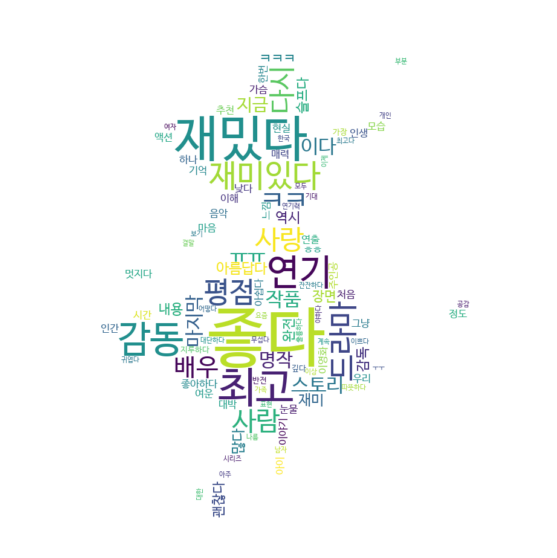

In [44]:
# 긍정 리뷰 - alice 마스크 이미지 이용
alice_mask = np.array(Image.open("alice_mask.png"))

wordcloud = WordCloud(
    font_path = font_path,
    width = 800,            
    height = 800,
    background_color="white",
    mask = alice_mask
)

wordcloud = wordcloud.generate_from_frequencies(dict(tags_posi))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# 파일로 저장하기
plt.savefig('posi_alice_wordcloud_movie_review.png', dpi=300)

plt.show()

**본 문서는 국토연구원 코딩 교육을 위한 목적으로 제작되었습니다.  
동의 없는 원외 무단 배포를 절대 금합니다.**